# Saved data preview

In [6]:
data_folder='demonstration/data'

## 1. Preview the data

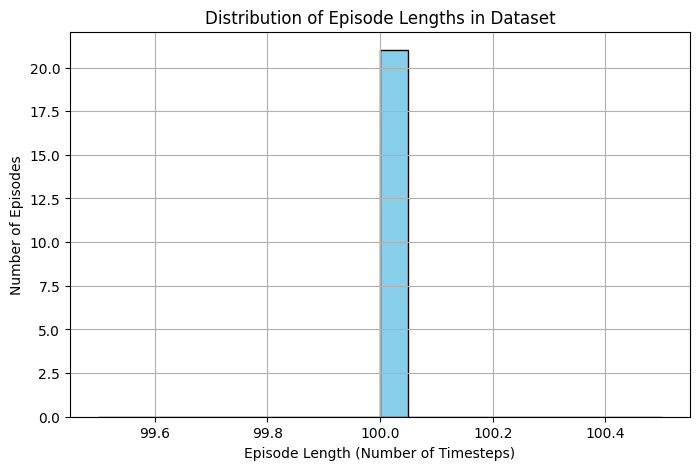

Number of episodes: 21
Min length: 100
Max length: 100
Mean length: 100.00
Median length: 100
Files with shortest episodes:
  episode_0.hdf5: 100
  episode_1.hdf5: 100
  episode_10.hdf5: 100
Files with longest episodes:
  episode_0.hdf5: 100
  episode_1.hdf5: 100
  episode_10.hdf5: 100

Data shape information for each data type:
  action:
    shape (100, 14): 21 episodes
    --> All episodes have the same shape for 'action'.
  qpos:
    shape (100, 14): 21 episodes
    --> All episodes have the same shape for 'qpos'.
  qvel:
    shape (100, 14): 21 episodes
    --> All episodes have the same shape for 'qvel'.


In [7]:
# Plot the distribution of episode lengths (time steps) in the hdf5 files

import h5py
import os
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

episode_lengths = []
episode_files = []

# To store shapes for each data type
data_shapes = defaultdict(list)  # {data_type: [shape, ...]}
data_types = set()

for file in os.listdir(data_folder):
    if file.endswith('.hdf5'):
        file_path = os.path.join(data_folder, file)
        with h5py.File(file_path, 'r') as f:
            # Assume 'qpos' is a time series: first dimension is episode length
            length = f['observations']['qpos'].shape[0]
            episode_lengths.append(length)
            episode_files.append(file)
            # Collect shapes for all datasets under 'observations'
            obs_group = f['observations']
            for key in obs_group.keys():
                if isinstance(obs_group[key], h5py.Dataset):
                    shape = obs_group[key].shape
                    data_shapes[key].append(shape)
                    data_types.add(key)
            # Also check for top-level datasets (e.g., 'action')
            for key in f.keys():
                if isinstance(f[key], h5py.Dataset):
                    shape = f[key].shape
                    data_shapes[key].append(shape)
                    data_types.add(key)
                elif isinstance(f[key], h5py.Group):
                    # Already handled 'observations' above
                    continue

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.hist(episode_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Episode Length (Number of Timesteps)')
plt.ylabel('Number of Episodes')
plt.title('Distribution of Episode Lengths in Dataset')
plt.grid(True)
plt.show()

# Optionally, print some stats
print(f"Number of episodes: {len(episode_lengths)}")
if episode_lengths:
    print(f"Min length: {min(episode_lengths)}")
    print(f"Max length: {max(episode_lengths)}")
    print(f"Mean length: {sum(episode_lengths)/len(episode_lengths):.2f}")
    print(f"Median length: {sorted(episode_lengths)[len(episode_lengths)//2]}")
    # Optionally, print outliers or file names for very short/long episodes
    print("Files with shortest episodes:")
    for f, l in sorted(zip(episode_files, episode_lengths), key=lambda x: x[1])[:3]:
        print(f"  {f}: {l}")
    print("Files with longest episodes:")
    for f, l in sorted(zip(episode_files, episode_lengths), key=lambda x: -x[1])[:3]:
        print(f"  {f}: {l}")

# Print data shape info for each data type
print("\nData shape information for each data type:")
for dtype in sorted(data_types):
    shapes = data_shapes[dtype]
    shape_counts = Counter(shapes)
    print(f"  {dtype}:")
    for shape, count in shape_counts.items():
        print(f"    shape {shape}: {count} episodes")
    if len(shape_counts) == 1:
        print(f"    --> All episodes have the same shape for '{dtype}'.")
    else:
        print(f"    --> WARNING: Not all episodes have the same shape for '{dtype}'.")


In [8]:
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt

def review_episode_sample(hdf5_name=None, data_folder='../data'):
    """
    Review and visualize a sample episode from the dataset.
    If hdf5_name is provided, show info for that file.
    If hdf5_name is None, pick a random episode from all .hdf5 files in data_folder.
    Additionally, show the data range and distribution for each action column.
    """
    import random

    # List all .hdf5 files in the data_folder
    if not os.path.isdir(data_folder):
        print(f"Data folder '{data_folder}' does not exist.")
        return

    episode_files = [f for f in os.listdir(data_folder) if f.endswith('.hdf5')]
    if not episode_files:
        print("No episode files found to review.")
        return

    # Determine which file to review
    if hdf5_name is not None:
        if hdf5_name in episode_files:
            sample_file = hdf5_name
        else:
            print(f"Provided hdf5_name '{hdf5_name}' not found in '{data_folder}'.")
            return
    else:
        sample_file = random.choice(episode_files)

    sample_path = os.path.join(data_folder, sample_file)
    print(f"\nReviewing sample episode: {sample_file}")

    with h5py.File(sample_path, 'r') as f:
        # List available datasets/groups
        print("Available datasets/groups in this file:")
        def print_tree(name, obj):
            print("  " + name)
        f.visititems(print_tree)

        # Plot a sequence (e.g., qpos, qvel, action)
        obs = f['observations']
        qpos = obs['qpos'][:]
        print(f"qpos shape: {qpos.shape}")
        plt.figure(figsize=(12, 4))
        for i in range(min(qpos.shape[1], 7)):  # Plot up to 7 joints
            plt.plot(qpos[:, i], label=f'qpos[{i}]')
        plt.title('qpos (first 7 joints) over time')
        plt.xlabel('Timestep')
        plt.ylabel('qpos value')
        plt.legend()
        plt.show()

        # Plot qvel if available
        if 'qvel' in obs:
            qvel = obs['qvel'][:]
            print(f"qvel shape: {qvel.shape}")
            plt.figure(figsize=(12, 4))
            for i in range(min(qvel.shape[1], 7)):  # Plot up to 7 joints
                plt.plot(qvel[:, i], label=f'qvel[{i}]')
            plt.title('qvel (first 7 joints) over time')
            plt.xlabel('Timestep')
            plt.ylabel('qvel value')
            plt.legend()
            plt.show()
        else:
            print("No 'qvel' dataset found in 'observations'.")

        # If available, plot action and show data range/distribution for each column
        if 'action' in f:
            action = f['action'][:]
            print(f"action shape: {action.shape}")

            # Show time series for first 7 dims as before
            plt.figure(figsize=(12, 4))
            for i in range(min(action.shape[1], 7)):
                plt.plot(action[:, i], label=f'action[{i}]')
            plt.title('action (first 7 dims) over time')
            plt.xlabel('Timestep')
            plt.ylabel('action value')
            plt.legend()
            plt.show()

            # Show distribution and range for all columns
            n_cols = action.shape[1]
            n_plots = n_cols
            ncols = 4
            nrows = int(np.ceil(n_plots / ncols))
            plt.figure(figsize=(4 * ncols, 3 * nrows))
            for i in range(n_cols):
                plt.subplot(nrows, ncols, i+1)
                plt.hist(action[:, i], bins=30, color='skyblue', edgecolor='black')
                col_min = np.min(action[:, i])
                col_max = np.max(action[:, i])
                plt.title(f'action[{i}]\nmin={col_min:.4f}, max={col_max:.4f}')
                plt.xlabel('Value')
                plt.ylabel('Count')
                # Mark min/max with vertical lines
                plt.axvline(col_min, color='red', linestyle='--', label='min')
                plt.axvline(col_max, color='green', linestyle='--', label='max')
                plt.legend(fontsize=8)
            plt.tight_layout()
            plt.suptitle(f"Distribution and Range of Each Action Dimension\n(Episode: {sample_file})", y=1.02, fontsize=16)
            plt.show()

            # Print the range for each column
            print("Action column ranges:")
            for i in range(n_cols):
                col_min = np.min(action[:, i])
                col_max = np.max(action[:, i])
                print(f"  action[{i}]: min={col_min:.6f}, max={col_max:.6f}")

        # Show some image samples if present
        if 'images' in obs:
            image_group = obs['images']
            cam_names = list(image_group.keys())
            if cam_names:
                # Plot for all cameras, including wrist_cam_left and wrist_cam_right if present
                for cam in cam_names:
                    imgs = image_group[cam]
                    print(f"Image dataset '{cam}' shape: {imgs.shape}")
                    # Show first, middle, last frame
                    idxs = [0, len(imgs)//2, len(imgs)-1] if len(imgs) > 2 else list(range(len(imgs)))
                    plt.figure(figsize=(15, 5))
                    for i, idx in enumerate(idxs):
                        plt.subplot(1, len(idxs), i+1)
                        img = imgs[idx]
                        plt.imshow(img)
                        plt.title(f"{cam} frame {idx}")
                        plt.axis('off')
                    plt.suptitle(f"Sample images from '{cam}' in episode '{sample_file}'")
                    plt.show()
            else:
                print("No image datasets found in 'observations/images'.")
        else:
            print("No 'images' group found in 'observations'.")




Reviewing sample episode: episode_46.hdf5
Available datasets/groups in this file:
  action
  observations
  observations/images
  observations/images/overhead_cam
  observations/images/teleoperator_pov
  observations/images/wrist_cam_left
  observations/images/wrist_cam_right
  observations/qpos
  observations/qvel
qpos shape: (100, 14)


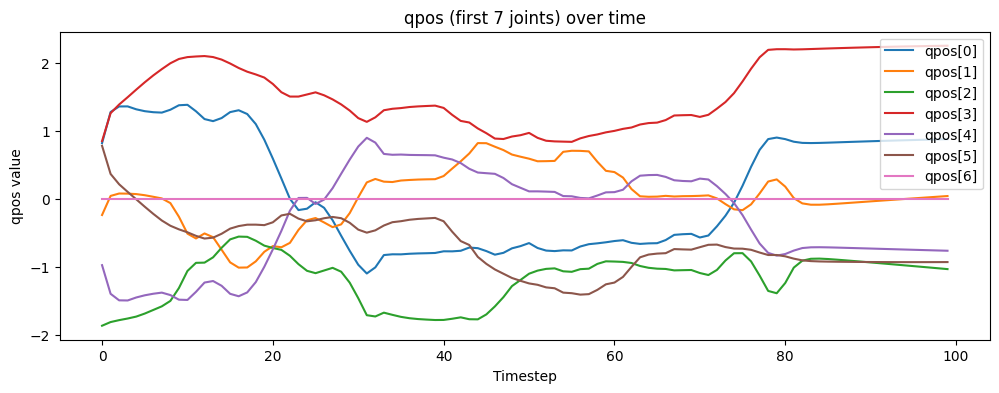

qvel shape: (100, 14)


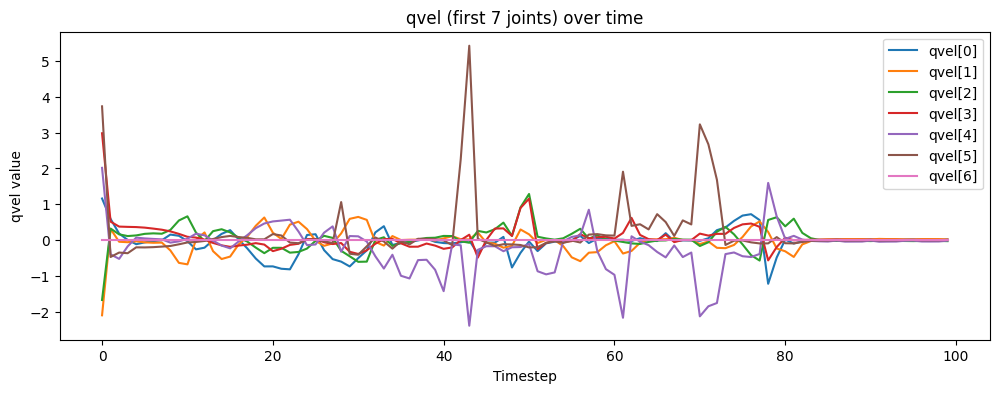

action shape: (100, 14)


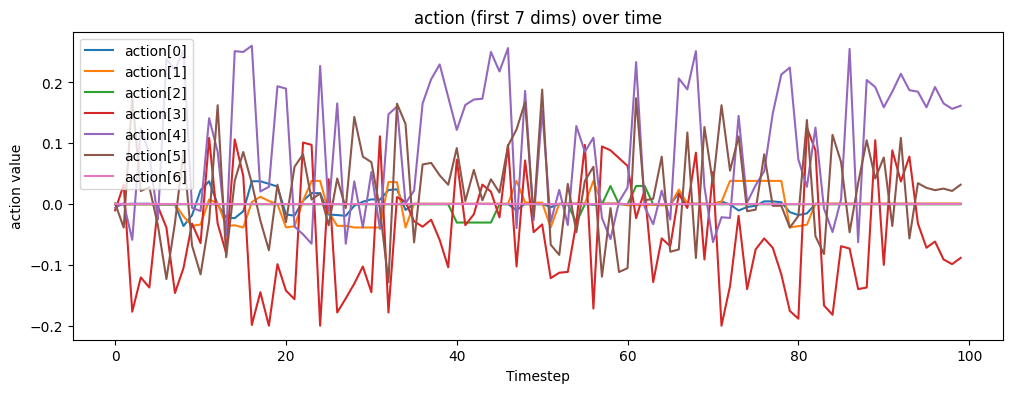

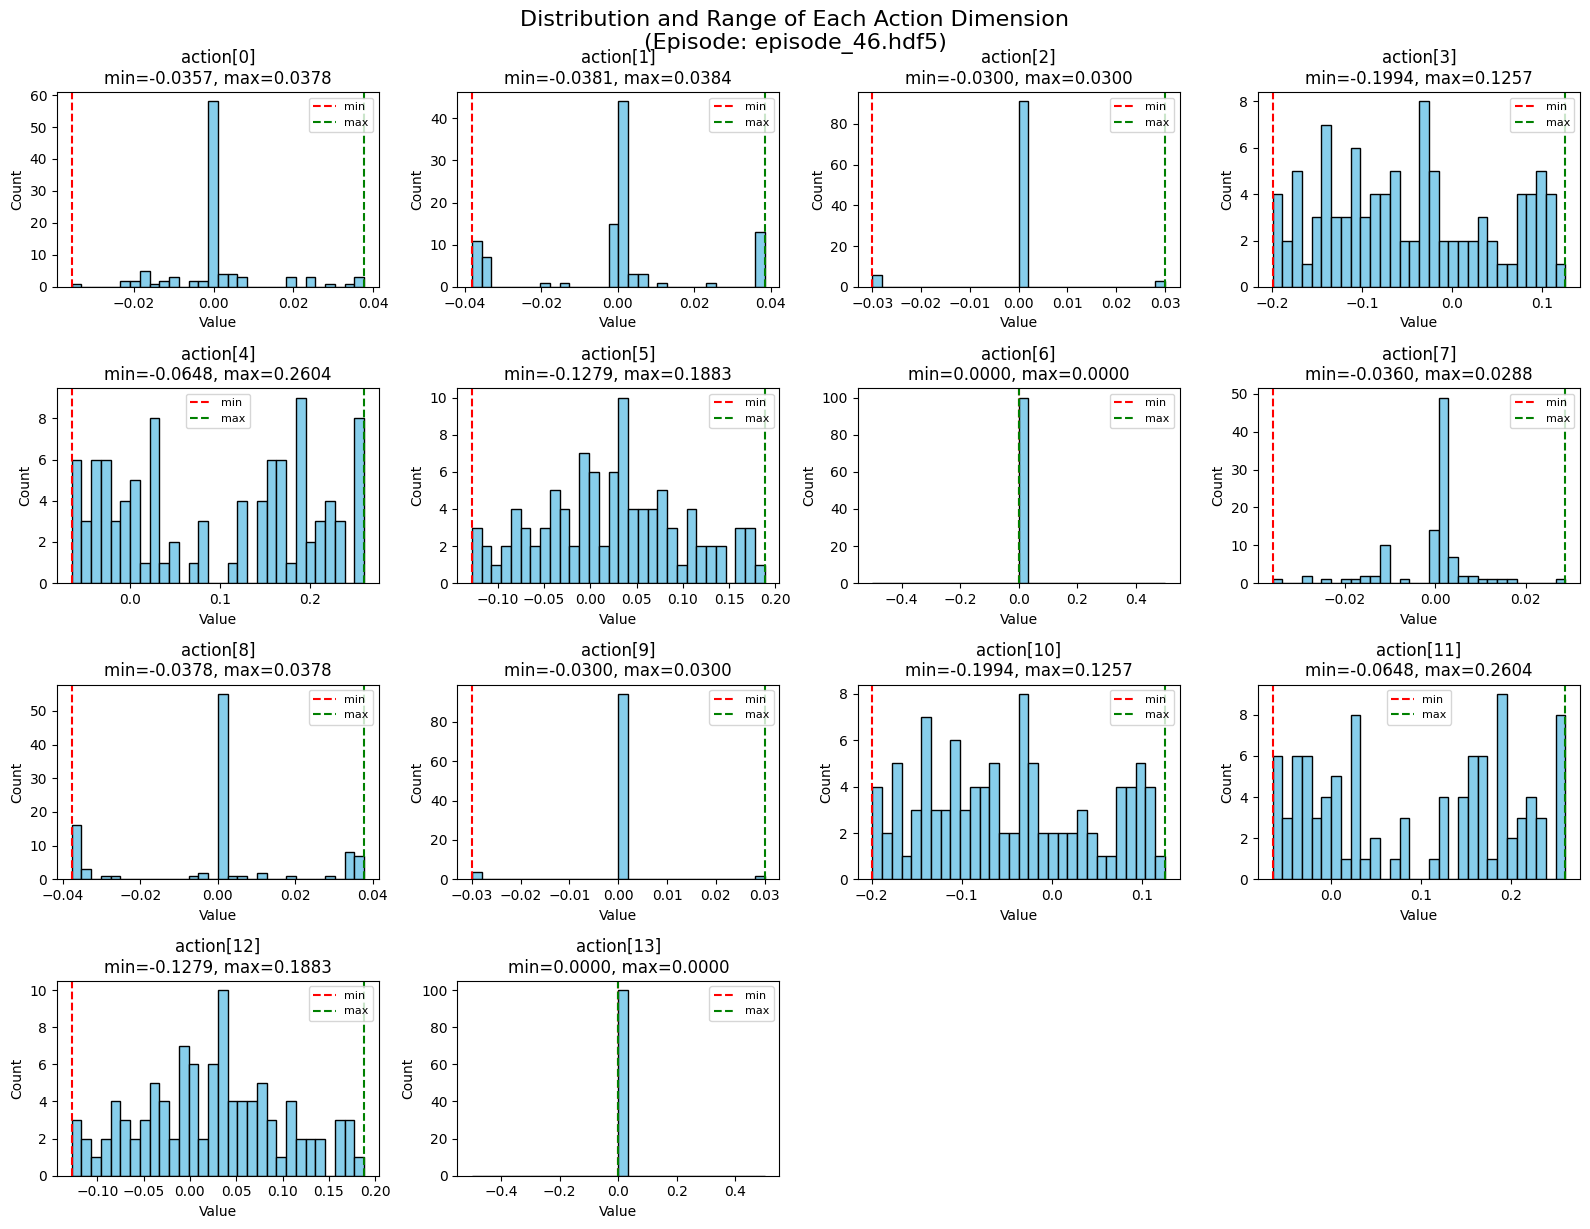

Action column ranges:
  action[0]: min=-0.035700, max=0.037800
  action[1]: min=-0.038100, max=0.038400
  action[2]: min=-0.030000, max=0.030000
  action[3]: min=-0.199411, max=0.125704
  action[4]: min=-0.064756, max=0.260369
  action[5]: min=-0.127882, max=0.188278
  action[6]: min=0.000000, max=0.000000
  action[7]: min=-0.036000, max=0.028800
  action[8]: min=-0.037800, max=0.037800
  action[9]: min=-0.030000, max=0.030000
  action[10]: min=-0.199411, max=0.125704
  action[11]: min=-0.064756, max=0.260369
  action[12]: min=-0.127882, max=0.188278
  action[13]: min=0.000000, max=0.000000
Image dataset 'overhead_cam' shape: (100, 480, 640, 3)


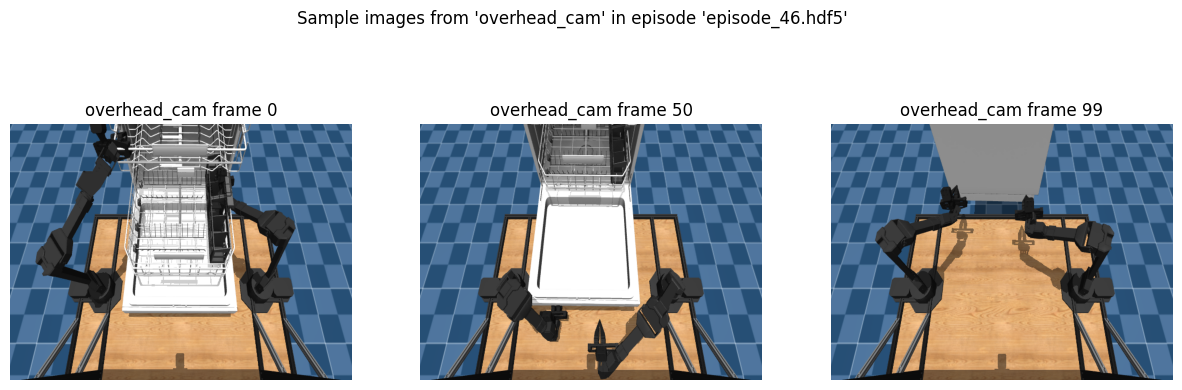

Image dataset 'teleoperator_pov' shape: (100, 480, 640, 3)


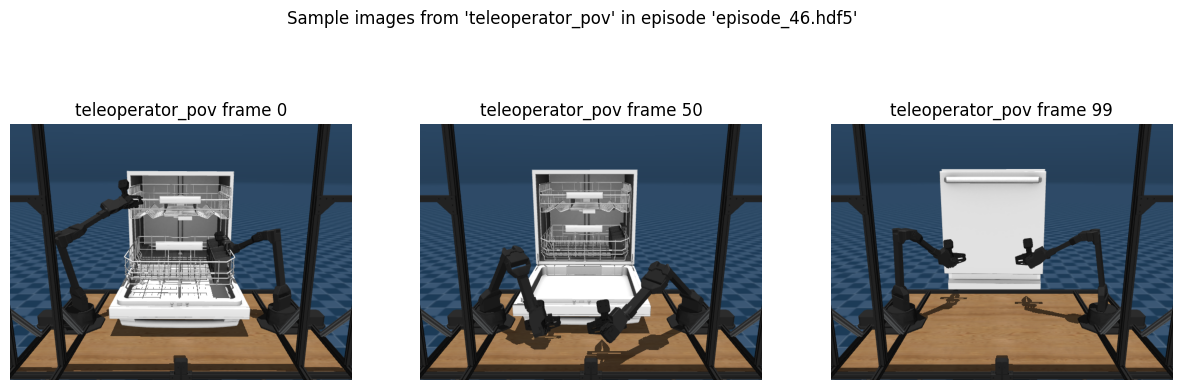

Image dataset 'wrist_cam_left' shape: (100, 480, 640, 3)


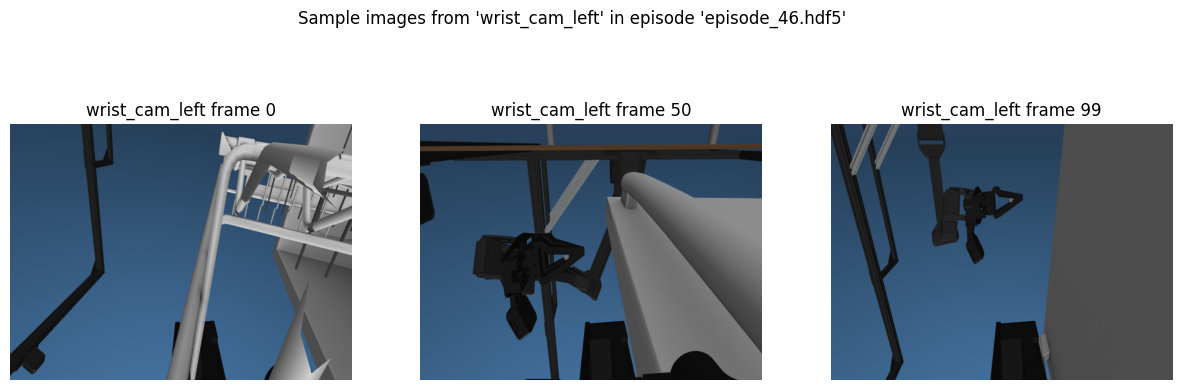

Image dataset 'wrist_cam_right' shape: (100, 480, 640, 3)


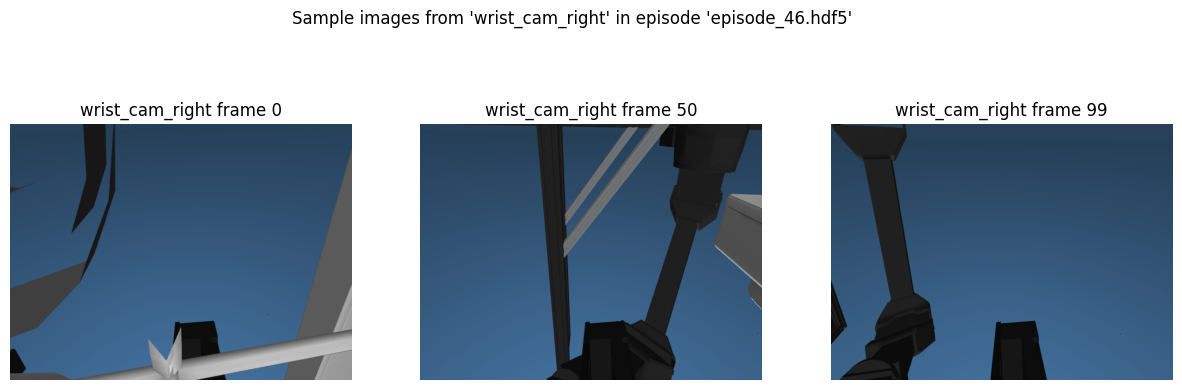

In [2]:
# Example usage:
review_episode_sample()  # random sample from ../data

# review_episode_sample(hdf5_name='episode_0.hdf5', data_folder='./my_data')

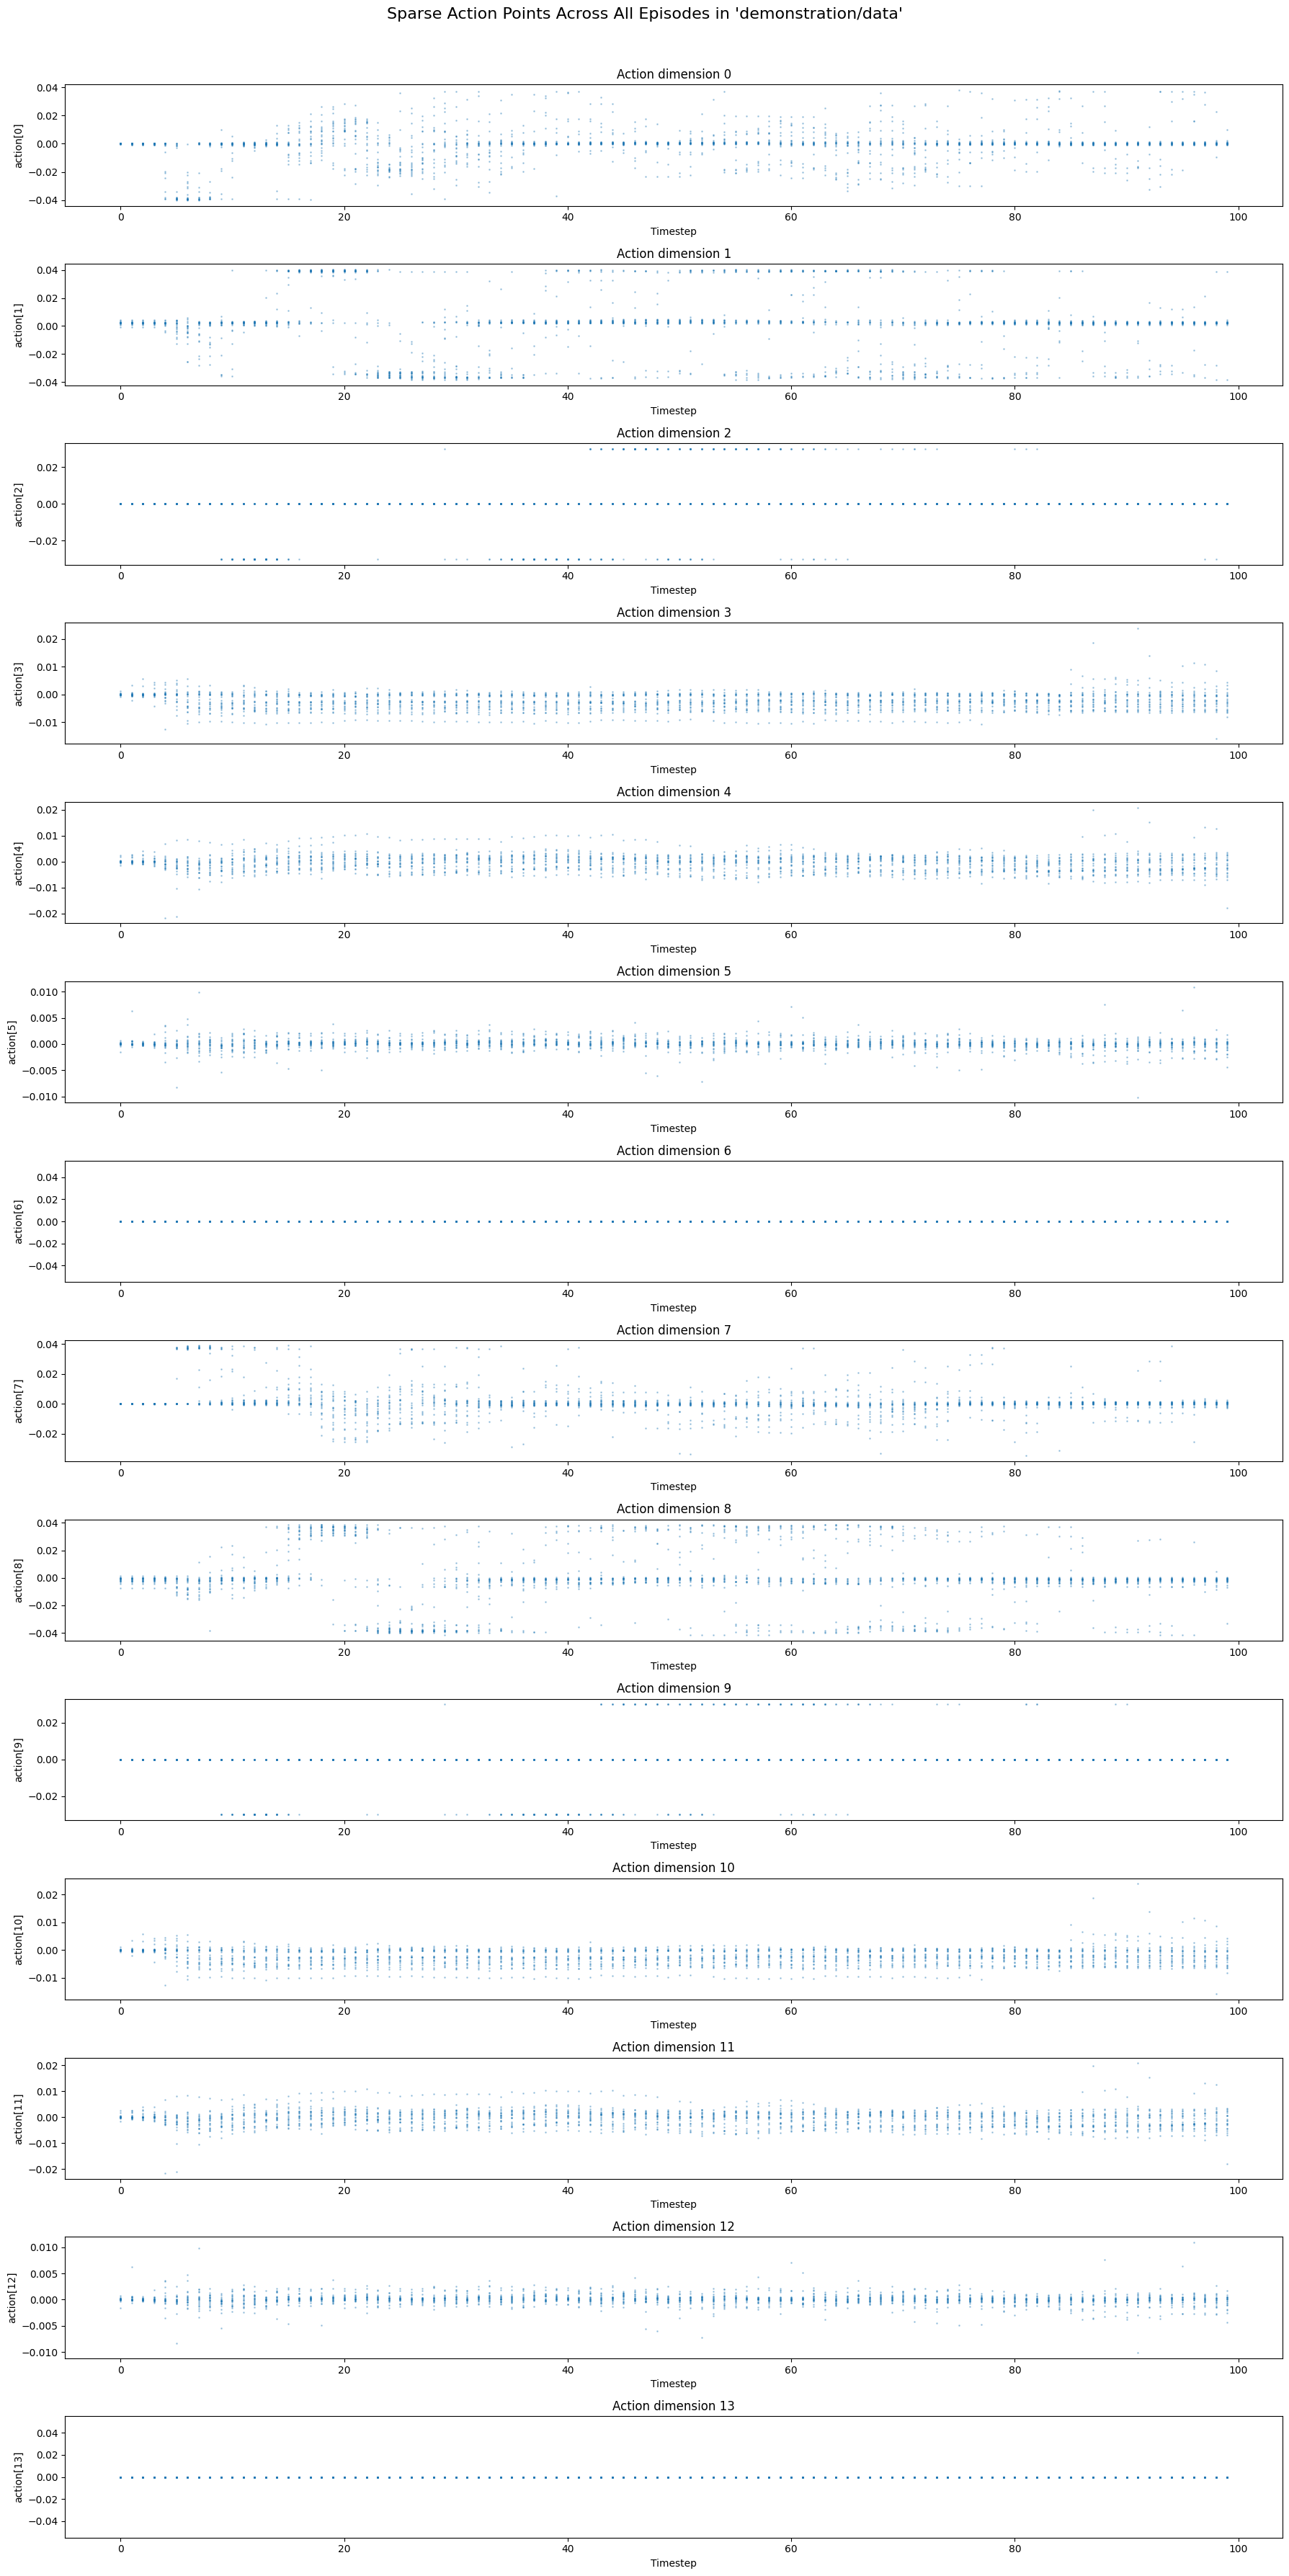

In [10]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

def plot_sparse_actions_from_folder(data_folder):
    """
    For each episode hdf5 file in the given folder, plot all action data as sparse dots.
    Each subplot corresponds to one action dimension, and all episodes are overlaid.
    All actions are plotted in the same color (no per-episode color distinction).
    """
    # Find all hdf5 files in the folder
    h5_files = [f for f in os.listdir(data_folder) if f.endswith('.hdf5')]
    if not h5_files:
        print(f"No hdf5 files found in {data_folder}")
        return

    # First, determine action dimension from the first file
    first_file = os.path.join(data_folder, h5_files[0])
    with h5py.File(first_file, 'r') as f:
        if 'action' not in f:
            print(f"No 'action' dataset in {h5_files[0]}")
            return
        action_dim = f['action'].shape[1]
    
    plt.figure(figsize=(18, 2.5 * action_dim))
    for i in range(action_dim):
        plt.subplot(action_dim, 1, i+1)
        # Collect all actions for this dimension across all episodes
        all_actions = []
        all_timesteps = []
        for fname in h5_files:
            fpath = os.path.join(data_folder, fname)
            with h5py.File(fpath, 'r') as f:
                if 'action' not in f:
                    continue
                actions = f['action'][:]
                timesteps = np.arange(len(actions))
                all_actions.append(actions[:, i])
                all_timesteps.append(timesteps)
        # Concatenate all actions and timesteps for this dimension
        if all_actions:
            all_actions_flat = np.concatenate(all_actions)
            all_timesteps_flat = np.concatenate(all_timesteps)
            plt.plot(all_timesteps_flat, all_actions_flat, '.', alpha=0.3, color='C0', markersize=2)
        plt.ylabel(f"action[{i}]")
        plt.xlabel("Timestep")
        plt.title(f"Action dimension {i}")
    plt.tight_layout()
    plt.suptitle(f"Sparse Action Points Across All Episodes in '{data_folder}'", y=1.02, fontsize=16)
    plt.show()

# Example usage:
plot_sparse_actions_from_folder('demonstration/data')

In [13]:
import pandas as pd

# Two CSV files: executed actions and policy predictions actions
csv_ext = "demonstration/infer-data/executed_actions_20250906_143649_pqi10_zg3_tw10.csv"
csv_pred = "demonstration/infer-data/policy_preds_20250906_143649_pqi10_zg3_tw10.csv"

# Read the CSVs
df_ext = pd.read_csv(csv_ext)
df_pred = pd.read_csv(csv_pred)

# Print the column names of each CSV
print("Executed Actions CSV columns:")
print(df_ext.columns.tolist())

print("\nPolicy Predictions Actions CSV columns:")
print(df_pred.columns.tolist())

Executed Actions CSV columns:
['timestamp', 'step', 'loop_iter', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13']

Policy Predictions Actions CSV columns:
['timestamp', 'step', 'loop_iter', 'pred_index', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13']


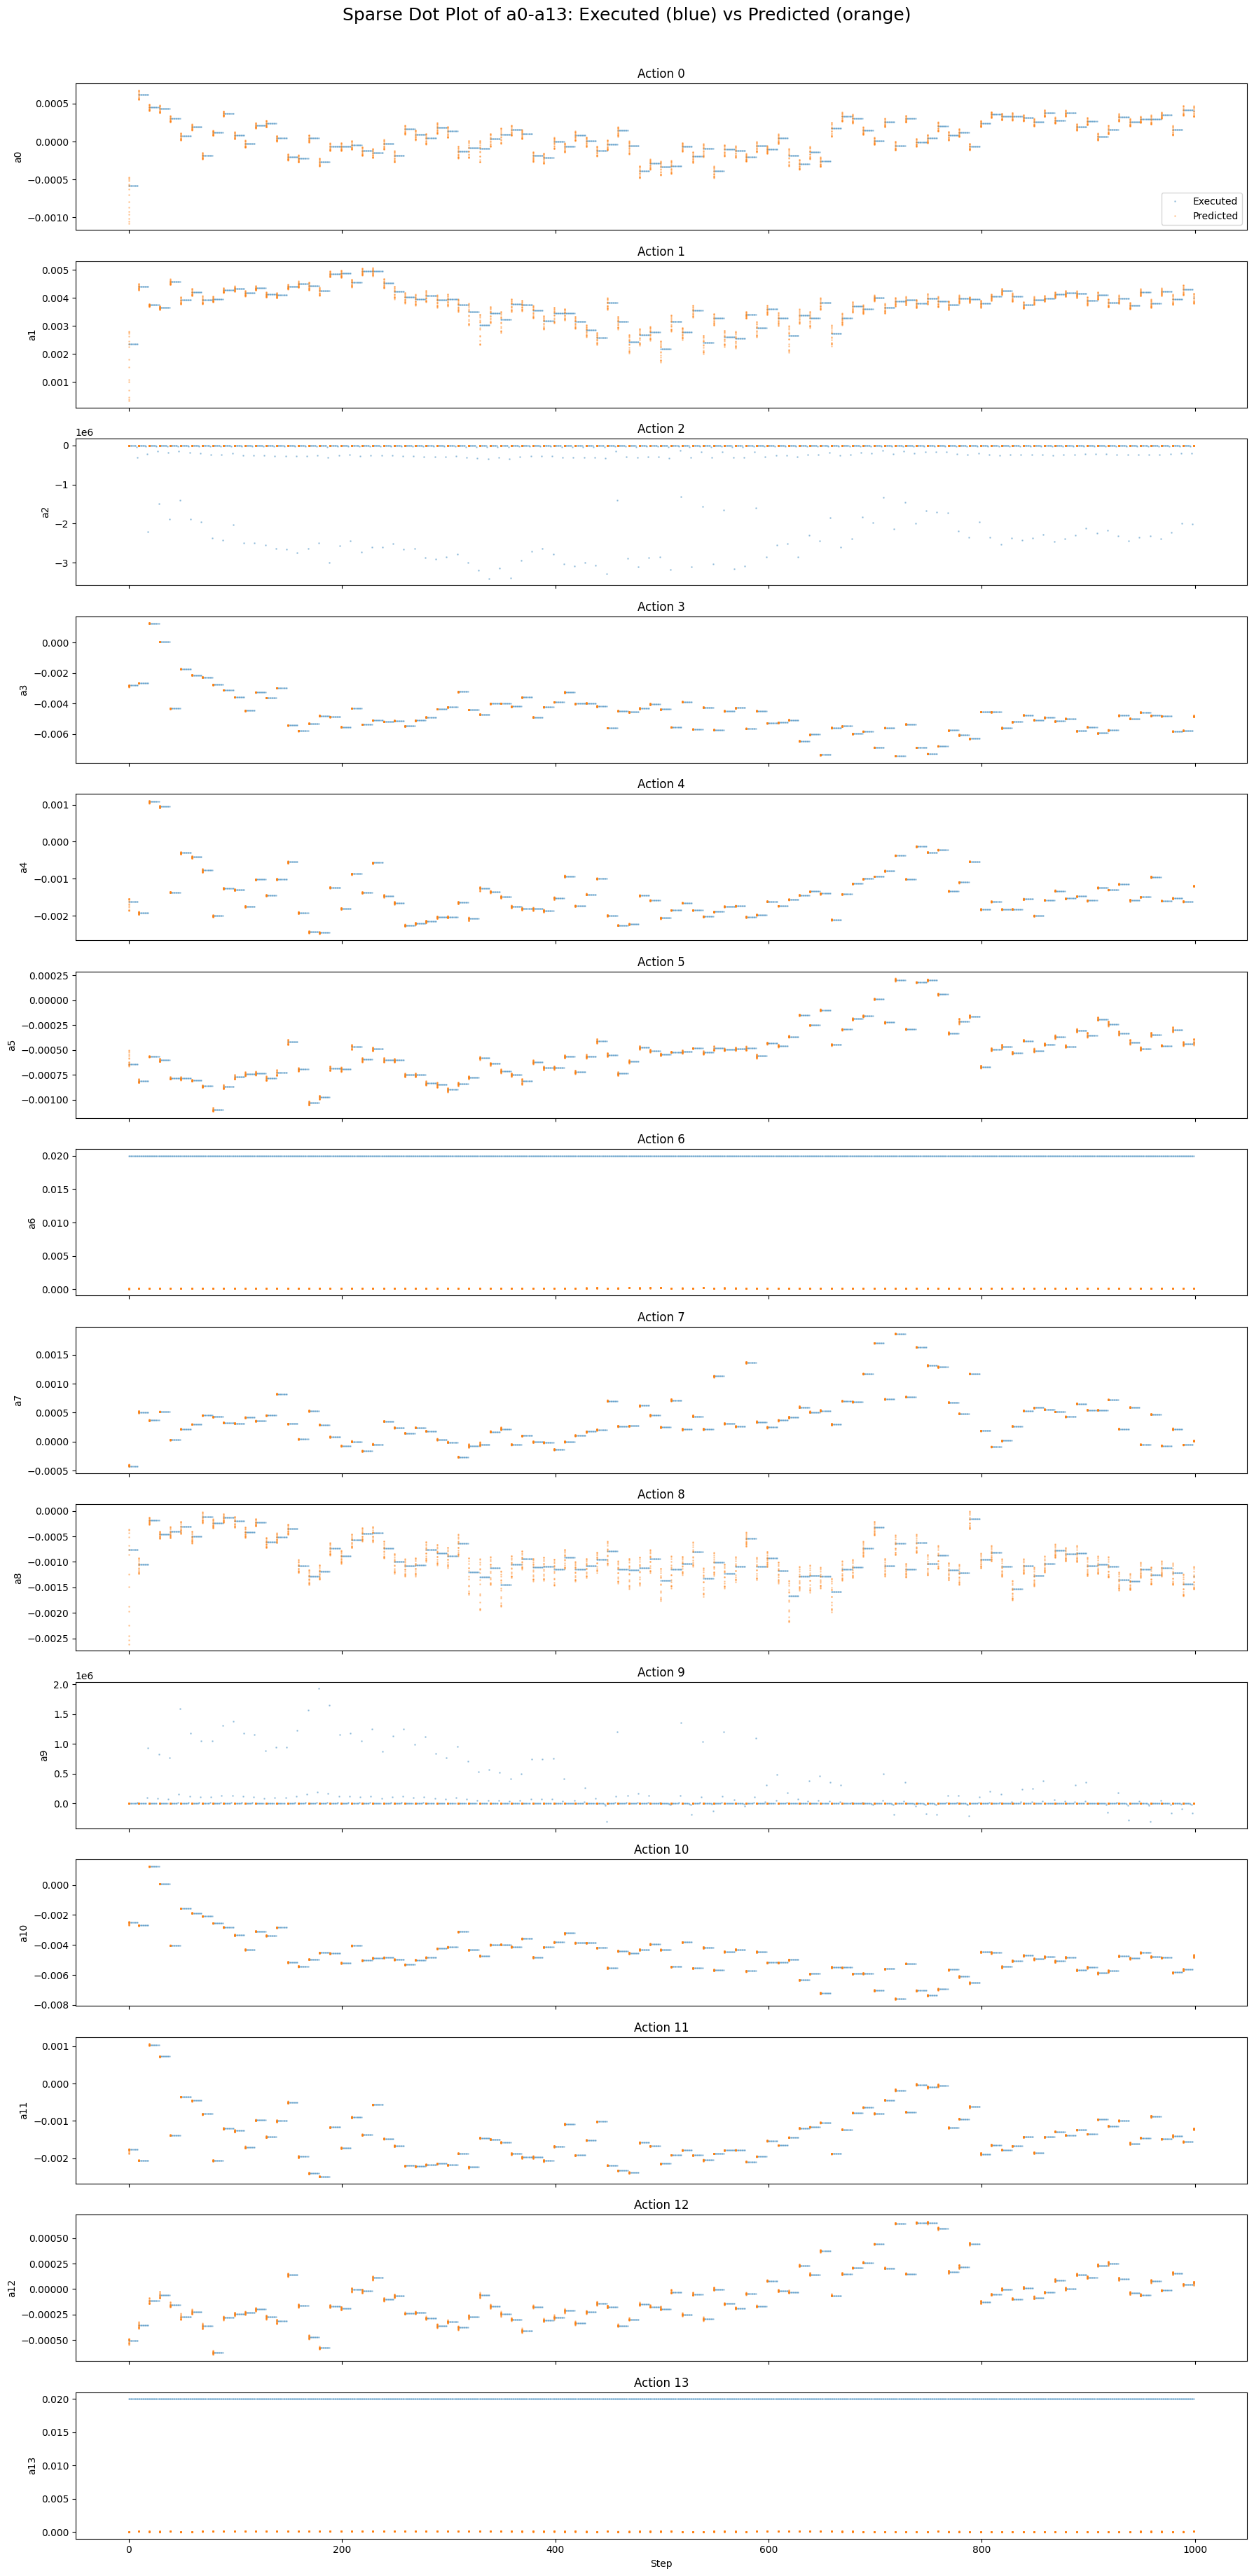

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_sparse_actions_from_csvs(csv_ext, csv_pred):
    """
    Plot sparse dot plots for a0 to a13 from two CSVs (executed and predicted actions).
    X-axis is step, y-axis is a{i}. Executed and predicted are shown in different colors.
    Each row shows one action's plot (14 rows, 1 column).
    """
    # Read CSVs
    df_ext = pd.read_csv(csv_ext)
    df_pred = pd.read_csv(csv_pred)

    fig, axes = plt.subplots(14, 1, figsize=(18, 36), sharex=True)
    if not isinstance(axes, np.ndarray):
        axes = [axes]

    for i in range(14):
        ax = axes[i]
        col = f'a{i}'
        # Only plot if both CSVs have the column
        if col in df_ext.columns and col in df_pred.columns:
            ax.plot(df_ext['step'], df_ext[col], '.', alpha=0.3, color='C0', markersize=2, label='Executed')
            ax.plot(df_pred['step'], df_pred[col], '.', alpha=0.3, color='C1', markersize=2, label='Predicted')
        ax.set_ylabel(col)
        ax.set_title(f'Action {i}')
        if i == 0:
            ax.legend()
    axes[-1].set_xlabel('Step')
    plt.tight_layout()
    plt.suptitle("Sparse Dot Plot of a0-a13: Executed (blue) vs Predicted (orange)", y=1.02, fontsize=18)
    plt.show()

# Example usage:
csv_ext = "demonstration/infer-data/executed_actions_20250906_162726_pqi10_zg10_tw15.csv"
csv_pred = "demonstration/infer-data/policy_preds_20250906_162726_pqi10_zg10_tw15.csv"
plot_sparse_actions_from_csvs(csv_ext, csv_pred)